In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score


pd.set_option("display.max_colwidth", -1)

In [43]:
df = pd.read_csv('../data/satireornot.csv')

In [44]:
df.shape

(37894, 2)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37894 entries, 0 to 37893
Data columns (total 2 columns):
text     37894 non-null object
label    37894 non-null int64
dtypes: int64(1), object(1)
memory usage: 592.2+ KB


In [46]:
df.columns

Index(['text', 'label'], dtype='object')

In [47]:
df.head(1)

,text,label
0,Planned Parenthood Mounts Giant IUD Atop Headquarters To Harness Sperm-Killing Power Of Lightning,1


In [48]:
df['text'] = df['text'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

In [49]:
df.shape

(37894, 2)

In [50]:
df["text_length"]= df['text'].str.len()
df['text_word_count'] = df['text'].map(lambda x: len(x.split()))


In [51]:
df.head()

,text,label,text_length,text_word_count
0,Planned Parenthood Mounts Giant IUD Atop Headquarters To Harness Sperm-Killing Power Of Lightning,1,97,13
1,Teachers React To Yet Another School Shooting,1,45,7
2,Children Of All Ages Delighted By Enslavement Of Topsy The Elephant,1,67,11
3,Texas Passes Mandatory 24-Hour Waiting Period Before Police Can Engage Active Shooters,1,86,12
4,School Practices Drill For When There’s Not An Active Shooter,1,61,10


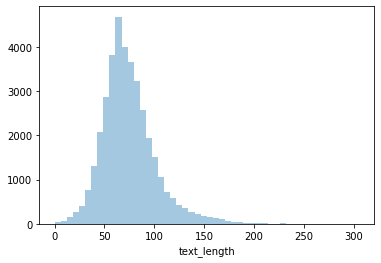

In [54]:
sns.distplot(df['text_length'], kde=False);

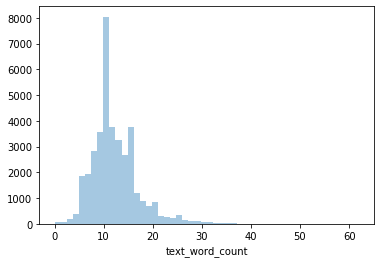

In [53]:
sns.distplot(df['text_word_count'], kde=False);

In [55]:
df = df[df['text_word_count'] > 3]
#omitted because observations this short were not headlines, just commentary

In [56]:
df.columns

Index(['text', 'label', 'text_length', 'text_word_count'], dtype='object')

#### Sentiment for text

In [57]:
corpus = list(df['text'])

#instantiate SIA
sia = SentimentIntensityAnalyzer()

#Get polarity scores for the first tweet
sia.polarity_scores(str(corpus[10]))

{'neg': 0.27, 'neu': 0.73, 'pos': 0.0, 'compound': -0.5719}

In [58]:
len(corpus)

37539

In [59]:
df.head(2)

,text,label,text_length,text_word_count
0,Planned Parenthood Mounts Giant IUD Atop Headquarters To Harness Sperm-Killing Power Of Lightning,1,97,13
1,Teachers React To Yet Another School Shooting,1,45,7


In [60]:
#create dataframe that contains text and the polarity scores for each headline

sentiment = []    

for text in corpus:
    scores = sia.polarity_scores(str(text))
    scores['text'] = text
    sentiment.append(scores)

sentiment = pd.DataFrame(sentiment)
sentiment.head()

,compound,neg,neu,pos,text
0,0.0000,0.000,1.000,0.000,Planned Parenthood Mounts Giant IUD Atop Headquarters To Harness Sperm-Killing Power Of Lightning
1,0.0000,0.000,1.000,0.000,Teachers React To Yet Another School Shooting
2,0.5106,0.000,0.752,0.248,Children Of All Ages Delighted By Enslavement Of Topsy The Elephant
3,0.6597,0.000,0.584,0.416,Texas Passes Mandatory 24-Hour Waiting Period Before Police Can Engage Active Shooters
4,-0.3089,0.201,0.799,0.000,School Practices Drill For When There’s Not An Active Shooter


In [61]:
sentiment.sort_values(by = 'pos', ascending = False).head()

,compound,neg,neu,pos,text
2386,0.8346,0.0,0.184,0.816,Please share to save lives!!!!!
27524,0.8625,0.0,0.189,0.811,Deadly super rainbow!!!! LOL
34672,0.8271,0.0,0.206,0.794,Patriots Win Super Bowl
23963,0.9020,0.0,0.213,0.787,/r/NotTheOnion's Best of 2014 Award Winners!
34473,0.8957,0.0,0.217,0.783,NotTheOnion's Best of 2016 Award Winners


In [62]:
sentiment.sort_values(by = 'neg', ascending = False).head()

,compound,neg,neu,pos,text
6303,-0.8591,0.895,0.105,0.0,Death Officially A Motherfucker
18943,-0.8807,0.836,0.164,0.0,Serial Killer Accidentally Kills Himself
26483,-0.9382,0.829,0.171,0.0,Florida police fatally shoot woman threatening suicide
27044,-0.9274,0.819,0.181,0.0,Suicide Bomb Instructor Accidentally Kills Iraqi Pupils
6951,-0.9201,0.814,0.186,0.0,Horrible Bitch Of An Ex-Girlfriend Missed Terribly


**Note to self**: consider adding custom stop words 

In [63]:
sentiment.shape

(37539, 5)

In [64]:
scores_df= sentiment[['compound', 'neg', 'neu', 'pos']]

**Note to self:** do ttests on sentiment scores to see if difference in scores are signficantly different between classes

In [38]:
#adding sentiment scores to original df

In [66]:
df_combined = pd.concat([df, scores_df], axis = 1)

In [67]:
df_combined.head()

,text,label,text_length,text_word_count,compound,neg,neu,pos
0,Planned Parenthood Mounts Giant IUD Atop Headquarters To Harness Sperm-Killing Power Of Lightning,1.0,97.0,13.0,0.0000,0.000,1.000,0.000
1,Teachers React To Yet Another School Shooting,1.0,45.0,7.0,0.0000,0.000,1.000,0.000
2,Children Of All Ages Delighted By Enslavement Of Topsy The Elephant,1.0,67.0,11.0,0.5106,0.000,0.752,0.248
3,Texas Passes Mandatory 24-Hour Waiting Period Before Police Can Engage Active Shooters,1.0,86.0,12.0,0.6597,0.000,0.584,0.416
4,School Practices Drill For When There’s Not An Active Shooter,1.0,61.0,10.0,-0.3089,0.201,0.799,0.000


In [68]:
df_combined.groupby('label').mean()[['pos', 'neg', 'neu', 'compound']]

,pos,neg,neu,compound
label,,,,
0.0,0.070082,0.137837,0.79208,-0.124882
1.0,0.089166,0.119066,0.79169,-0.057773


In [ ]:
# do T tests on sentiment scores between 0 and 1 class:

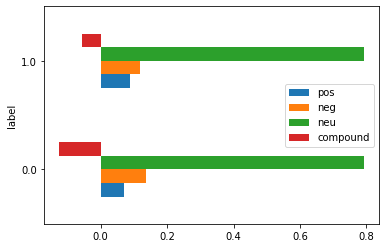

In [69]:
df_combined.groupby('label').mean()[['pos', 'neg', 'neu', 'compound']].plot(kind='barh')

In [71]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37893 entries, 0 to 37893
Data columns (total 8 columns):
text               37539 non-null object
label              37539 non-null float64
text_length        37539 non-null float64
text_word_count    37539 non-null float64
compound           37539 non-null float64
neg                37539 non-null float64
neu                37539 non-null float64
pos                37539 non-null float64
dtypes: float64(7), object(1)
memory usage: 2.6+ MB


In [72]:
df_combined.isnull().sum()

text               354
label              354
text_length        354
text_word_count    354
compound           354
neg                354
neu                354
pos                354
dtype: int64

In [73]:
df_combined.dropna(inplace = True)
#will lose 354/37539 = 0.009

In [74]:
#Prelim text vectorizing

In [75]:
cvec = CountVectorizer(stop_words = 'english', max_features = 3000, ngram_range = (1, 4))

vectors = cvec.fit_transform(df_combined['text'])


In [76]:
vector_df = pd.DataFrame(vectors.todense(), columns = cvec.get_feature_names())

In [77]:
vector_df.head()

,000,10,10 000,10 year,10 year old,10 years,100,11,11 year,11 year old,...,york times,young,youth,youtube,zealand,zimmerman,zombie,zone,zoo,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


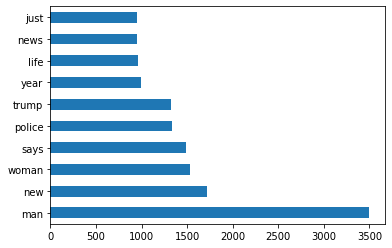

In [80]:
vector_df.sum().sort_values(ascending=False).head(10).plot(kind = 'barh')

In [96]:
df_combined.to_csv('satirevsreal.csv', index = False)